Files already downloaded and verified


Processing: 100%|██████████| 313/313 [00:28<00:00, 11.12it/s, Batch Train Loss=0.0040]


Validation Loss: 0.0036
Epoch [1/2] Average Train Loss: 0.0086, Average Validation Loss: 0.0036


Processing: 100%|██████████| 313/313 [00:22<00:00, 13.95it/s, Batch Train Loss=0.0027]


Validation Loss: 0.0027
Epoch [2/2] Average Train Loss: 0.0036, Average Validation Loss: 0.0027


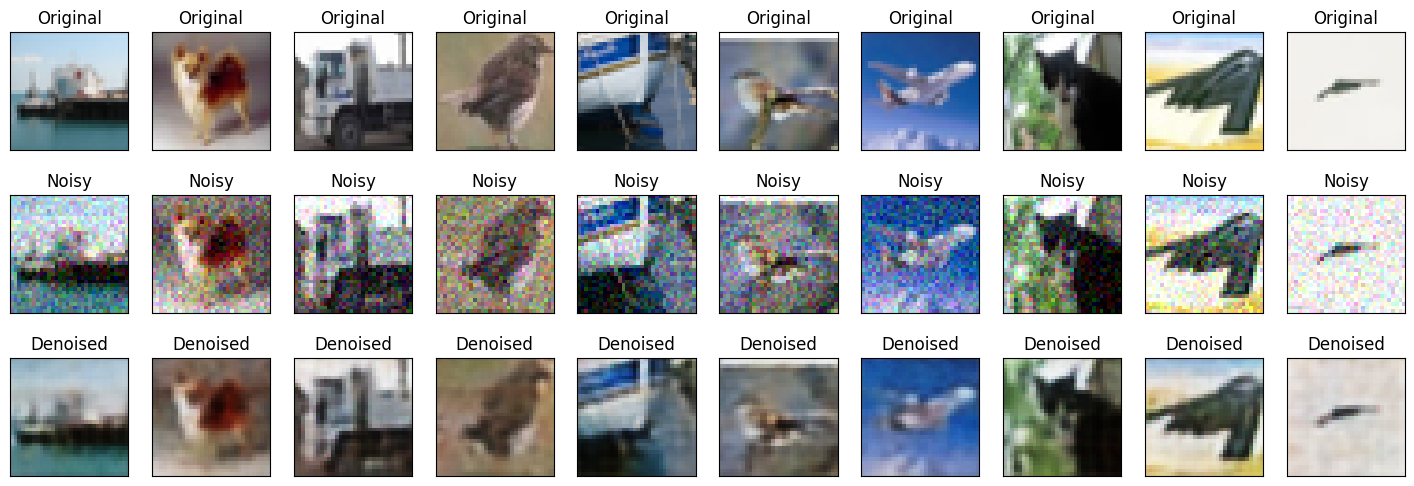

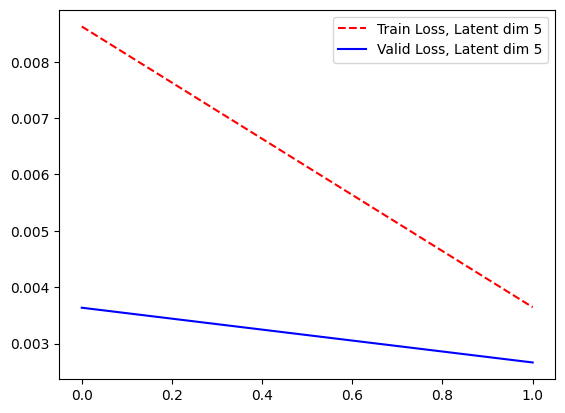

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from helper_functions import display_denoising_images
from training_functions import train_model, train_denoising_model, validate_model
from autoencoders import Autoencoder1, Autoencoder2
import torch.optim as optim
from tqdm import tqdm
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(0)

# Set environment variables
LATENT_DIMS = [5]
TRAIN_FUNCTION = train_denoising_model
MODEL = Autoencoder2
EPOCHS = 2
DEVICE = "mps"  # Replace with "cuda" if you have a GPU
NOISE_FACTOR = 0.1

# Load data and set DataLoader
transform = transforms.Compose([transforms.ToTensor()])
full_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

# Get some validation images
valid_dataiter = iter(valid_loader)
first_n_valid_images, _ = next(valid_dataiter)
first_n_valid_images = first_n_valid_images[:10]
input_dim = first_n_valid_images.shape[-1] * first_n_valid_images.shape[-2] * first_n_valid_images.shape[-3]

# Initialize a dictionary to store loss values for all latent dimensions
all_loss_values = {}

# Initialize tqdm for epochs
for latent_dim in LATENT_DIMS:
    epoch_train_loss = []
    epoch_valid_loss = []

    if MODEL == Autoencoder1:
        model = MODEL(input_dim=input_dim, latent_dim=latent_dim).to(DEVICE)
    else:
        model = MODEL(latent_dim=latent_dim).to(DEVICE)

    criterion = nn.MSELoss().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        pbar = tqdm(enumerate(train_loader), desc="Processing", total=len(train_loader), leave=True)  # Initialize tqdm for batches
        for batch_idx, (data, _) in pbar:
            if MODEL == Autoencoder1:
                if TRAIN_FUNCTION == train_denoising_model:
                    loss = train_denoising_model(model, data, NOISE_FACTOR, optimizer, criterion, DEVICE)
                else:
                    loss = TRAIN_FUNCTION(model, data, optimizer, criterion, DEVICE)
                train_loss += loss
            else:
                if TRAIN_FUNCTION == train_denoising_model:
                    loss = train_denoising_model(model, data, NOISE_FACTOR, optimizer, criterion, DEVICE, should_flatten=False)
                else:
                    loss = TRAIN_FUNCTION(model, data, optimizer, criterion, DEVICE, should_flatten=False)
                train_loss += loss

            # Update tqdm description for batches
            pbar.set_postfix({'Batch Train Loss': f"{loss:.4f}"})
        
        avg_train_loss = train_loss / len(train_loader)
        epoch_train_loss.append(avg_train_loss)

        model.eval()
        valid_loss = validate_model(model, valid_loader, device=DEVICE, should_flatten=False)
        epoch_valid_loss.append(valid_loss)

        print(f"Epoch [{epoch+1}/{EPOCHS}] Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {valid_loss:.4f}")

    all_loss_values[latent_dim] = {'train': epoch_train_loss, 'valid': epoch_valid_loss}

    # Display images
    display_denoising_images(10, first_n_valid_images, model, DEVICE, noise_factor=NOISE_FACTOR)

# Show the loss curves for all latent dimensions in a single plot
plt.figure()
for latent_dim, loss_values in all_loss_values.items():
    # Check if the objects are PyTorch tensors before converting them
    train_loss_cpu = [t.cpu().detach().numpy() if isinstance(t, torch.Tensor) else t for t in loss_values['train']]
    valid_loss_cpu = [t.cpu().detach().numpy() if isinstance(t, torch.Tensor) else t for t in loss_values['valid']]
  
    plt.plot(range(EPOCHS), np.array(train_loss_cpu), 'r--', label=f"Train Loss, Latent dim {latent_dim}")
    plt.plot(range(EPOCHS), np.array(valid_loss_cpu), 'b-', label=f"Valid Loss, Latent dim {latent_dim}")
  
plt.legend()
